<a href="https://colab.research.google.com/github/krumeto/article-vectorisation-eda/blob/main/Article_Vectorisation_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim==4.2.0
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 58.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 653 kB/s 
     |████████████████████████████████| 5.8 MB 53.5 MB/s 
     |████████████████████████████████| 1.3 MB 49.6 MB/s 
     |████████████████████████████████| 182 kB 55.8 MB/s 
     |████████████████████████████████| 7.6 MB 28.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e7c9b793729f44c61bfefb9795fd73e7ae042ab3982473495acaa92faaf5138b
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully bu

In [2]:
import pandas as pd
import numpy as np
from functools import wraps
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer, util
import torch

import gensim

In [3]:
def log_step(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tic = dt.datetime.now()
        result = func(*args, **kwargs)
        time_taken = str(dt.datetime.now() - tic)
        print(f"just ran step {func.__name__} shape={result.shape} took {time_taken}s")
        return result
    return wrapper

@log_step
def pull_data():
    return pd.read_csv('medium-articles.zip', usecols = ['title', 'text', 'tags'])

@log_step
def extract_first_tag(dataf):
    return dataf.assign(
        first_tag = lambda d: d['tags'].str.split(",", expand=True)[0].str.replace("[",'', regex=True)
        )
    
@log_step
def keep_topn_first_tags(dataf, n=10):
    top_n_tags = dataf['first_tag'].value_counts().nlargest(n).index.to_list()
    return dataf.loc[lambda d: d['first_tag'].isin(top_n_tags)]

@log_step
def drop_too_long_and_short_articles(dataf, low = 200, high = 2000):
    return (dataf.
            assign(appr_n_words = lambda d: d.text.str.split().str.len()).
            loc[lambda d: (d.appr_n_words > low) & (d.appr_n_words < high)].
            drop('appr_n_words', axis = 1)
          )

## Data Load and Split

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krumarnaudov","key":"c4e3cd41d3531ca569e9c494dcbd3f78"}'}

In [6]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d fabiochiusano/medium-articles

 99% 367M/369M [00:20<00:00, 22.5MB/s]
100% 369M/369M [00:20<00:00, 18.6MB/s]


In [ ]:
data = (pull_data().
        pipe(drop_too_long_and_short_articles).
        pipe(extract_first_tag).
        pipe(keep_topn_first_tags)
        )

just ran step pull_data shape=(192368, 3) took 0:00:18.183956s


In [ ]:
train_data, test_data =  train_test_split(data,test_size=0.10, random_state=42, stratify = data.first_tag)
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

train_data.head()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12172 entries, 39026 to 163160
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      12172 non-null  object
 1   text       12172 non-null  object
 2   tags       12172 non-null  object
 3   first_tag  12172 non-null  object
dtypes: object(4)
memory usage: 475.5+ KB


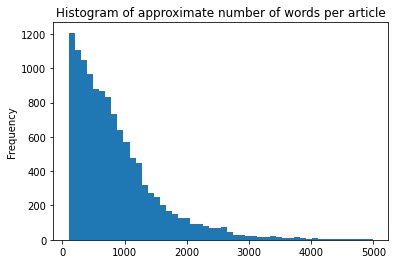

In [ ]:
(train_data.
 assign(appr_n_words = lambda d: d.text.str.split().str.len()).
 appr_n_words.
 plot.
 hist(bins = 50, title = 'Histogram of approximate number of words per article')
)

In [ ]:
train_data.first_tag.value_counts()

'Machine Learning'    1902
'Blockchain'          1457
'Self Improvement'    1265
'Politics'            1227
'Technology'          1209
'Life Lessons'        1207
'Programming'         1086
'Startup'             1081
'Cryptocurrency'       951
'Poetry'               787
Name: first_tag, dtype: int64

## TF-IDF 

In [ ]:
corpus = train_data.text

vectorizer = TfidfVectorizer(stop_words = 'english')
vectorized_corpus = vectorizer.fit_transform(corpus)

print(vectorized_corpus.shape)
print("Note that the rows are the number of documents, while the columns equal the number of tokens")

(12172, 121492)
Note that the rows are the number of documents, while the columns equal the number of tokens


In [ ]:
# Title is Optimizing Kafka for the cloud
new_document = ["""
By Ambud Sharma | Software Engineer, Logging team Takeaways Developing locality aware systems and balancing algorithms can help substantially reduce cost Making Kafka Producer and Consumer rack aware helps efficiently route traffic Data-driven engineering decision making is critical to continuously improve systems One of the fundamental principles when operating in the cloud is to ensure applications safeguard against outages. A common way to achieve this is to spread an application’s deployment across multiple failure domains. In a public cloud environment, Availability Zone (AZ) can serve as a failure domain. We can use multiple AZs to provide fault tolerance for an application. Distributed systems like HDFS are traditionally made rack aware to improve fault tolerance by spreading replicas across multiple racks within a datacenter. However, using AZs as rack information is a common practice when running in cloud environments. This enables spreading data copies across multiple AZs, thereby providing fault tolerance in case one fails. While replicating data across AZs provides fault tolerance, it does come at a premium in form of AZ transfer costs. At Pinterest, we use Kafka extensively as a scalable, fault tolerant distributed message bus to power several key services like user action counting and change data capture (CDC). Since we have Kafka running at a very large scale, we need to be mindful of AZ transfer costs and run as efficiently as possible, and so we focused on reducing the amount of data transferred across AZ. When a Kafka cluster has brokers spread across multiple AZs, it results in three types of cross AZ network traffic: Inter-broker replication traffic Traffic from Producers in different AZs Traffic from Consumers in different AZs Out of the above traffic types we need 1 for fault tolerance. However, 2 and 3 are unwanted side effects that cause additional cost which, in theory, can be eliminated. Design There are two potential ways to solve this problem. Approach 1 We can make our Producers and Consumers write/read data only for partitions whose leaders share the same AZ to make them more cost efficient. Approach 2 Alternatively we could deploy AZ specific Kafka clusters, but in order to achieve this any other real-time consumers would need to make their business logic AZ aware. In the interest of simplicity, we chose to go with Approach 1 since it minimized code and stack changes. Producer / Consumer AZ awareness can be achieved by looking up the rack information for the leader broker of the partition we are trying to read/write to, and change the partitioning logic for producers and assignments for consumer. In Kafka, the broker’s rack information is part of the PartitionInfo metadata object that is shared with Kafka clients (both consumers and producers). Therefore, we deployed rack awareness to our Kafka clusters, where each broker publishes the AZ it’s in as node rack info. We started this initiative with our biggest producer and consumer applications for Kafka, logging agent and S3 transporter. Producer AZ Awareness Our logging agent is responsible for reading data from log files and shipping them to Kafka in microbatches. The agent also lets users configure how logs are partitioned across a topic’s partitions. One key design of our logging agent is the ability to pre-partition the data before calling Kafka’s producer.send(). This allows us to add more advanced routing. To make it AZ aware, we added ability for the logging agent to look up AZ info for the node it’s running on using the EC2 Metadata API. Next, we enhanced our partitioner to leverage rack information in Kafka’s producer metadata to limit writes to only partitions for which leaders are in the same AZ as the logging agent. (This change was only applicable to topics that didn’t use key based partitioning since ordering couldn’t be guaranteed after AZ awareness change, as a partition switches AZ.) Consumer AZ Awareness S3 transporter is responsible for reading logs from Kafka and persisting them to S3 for further processing. We tried something similar to the producer for S3 transporter. Our S3 transporter doesn’t use Kafka consumer assignments. Rather, it uses its own partition assignment system. This allows us to preserve locality in case of node restarts or has temporary network isolation, thus reducing the amount of data that needs to be replayed for a given batch. We make each S3 transporter worker look up and publish its AZ info to Zookeeper, which helps the S3 transporter master assign Kafka partitions to the workers based on their rack (AZ). If we are unable to look up the (rack) AZ information of a partition, we degrade to assignment across all available workers. Results We rolled out AZ aware S3 transporter to production, which resulted in more than 25% savings in AZ transfer cost for Logging. We’re currently in the process of slowly rolling out AZ aware logging agent to further reduce our AZ transfer costs. We’re also working to extend this design to standard Kafka Producers and Consumers to help us extend our savings to other applications as well, which may include KIP-392 once it’s implemented. Acknowledgements: Huge thanks to Eric Lopez, Henry Cai, Heng Zhang, Ping-Min Lin, Vahid Hashemian, Yi Yin, Yinian Qi and Yu Yang who helped with improving Logging at Pinterest. Also, thanks to Kalim Moghul for helping us with this effort.
"""]

new_doc_vector = vectorizer.transform(new_document)

In [ ]:
sim = cosine_similarity(X = vectorized_corpus, Y = new_doc_vector)
sim

array([[0.00877191],
       [0.01637664],
       [0.0038085 ],
       ...,
       [0.00703571],
       [0.01135096],
       [0.01858134]])

In [ ]:
# Extract Index of Maximum valued similar document
argmax = np.argmax(sim)
print(f"Index of maximum valued similar data: {argmax}")
print("Retrieved Document Header:")
print(train_data['title'][argmax])
train_data["text"][argmax]

Index of maximum valued similar data: 8138
Retrieved Document Header:
What is Kafka?


'What is Kafka?\n\nWhat is Kafka?\n\nKafka is a streaming platform that can be used for storing, reading and processing data. It was founded by 3 engineers in LinkedIn since they needed something faster and more scalable than traditional MQ.\n\nFurther in the article we will learn why Kafka is faster then MQs.\n\nKafka topic\n\nKafka topic is the feed to which a producer pushes messages/records and a consumer subscribes to, to consume messages from it. A topic is something similar to a message queue, where data is pushed and popped from, the difference here is that messages are never popped from a Kafka topic. The topics can have a retention period configured, which would then automatically delete the messages which are older than the retention period.\n\nCommit log\n\nCommit log is an append-only data structure which is used by Kafka to store the records. This makes the messaging system durable, persistent, sequential and has better scalability and built-in fault tolerance since the l

## gensim's doc2vec

In [ ]:
train_data_preprocessed = [gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(article), [i])
    for i, article in enumerate([t for t in train_data.text])
]
train_data_preprocessed[0]

TaggedDocument(words=['wearable', 'technology', 'is', 'going', 'to', 'make', 'us', 'feel', 'sicker', 'than', 'we', 'actually', 'are', 'welcome', 'to', 'the', 'world', 'of', 'technology', 'driven', 'hypochondria', 'fuck', 'webmd', 'hear', 'me', 'out', 'have', 'you', 'ever', 'noticed', 'strange', 'red', 'bump', 'on', 'your', 'skin', 'or', 'felt', 'strange', 'pain', 'in', 'your', 'chest', 'or', 'basically', 'anything', 'that', 'then', 'led', 'you', 'down', 'webmd', 'rabbit', 'hole', 'causing', 'you', 'to', 'believe', 'that', 'your', 'dick', 'was', 'going', 'to', 'fall', 'off', 'while', 'your', 'skeleton', 'disintegrated', 'and', 'your', 'skin', 'melted', 'into', 'goo', 'like', 'that', 'dude', 'from', 'robocop', 'it', 'no', 'exaggeration', 'to', 'say', 'that', 'the', 'internet', 'has', 'turned', 'all', 'of', 'us', 'into', 'raging', 'hypochondriacs', 'interpreting', 'any', 'suspicious', 'body', 'pain', 'or', 'physical', 'ailment', 'as', 'death', 'knocking', 'on', 'our', 'slightly', 'creakin

In [ ]:
import logging
logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO
)

doc2vec_model = gensim.models.doc2vec.Doc2Vec(
    vector_size=50,
    min_count=2,
    epochs=2,
    dm=1
)

doc2vec_model.build_vocab(train_data_preprocessed)

doc2vec_model.train(
    train_data_preprocessed,
    total_examples=doc2vec_model.corpus_count,
    epochs=doc2vec_model.epochs
)

In [ ]:
train_data_transformed = [gensim.utils.simple_preprocess(doc) for doc in train_data.text]
gensim_vectors = [doc2vec_model.infer_vector(doc) for doc in train_data_transformed]

In [ ]:
np.array(gensim_vectors).shape

(12172, 50)

In [ ]:
new_doc_gensim_vector = doc2vec_model.infer_vector(gensim.utils.simple_preprocess(new_document[0]))

In [ ]:
sim_gensim = cosine_similarity(X = np.array(gensim_vectors), Y = np.array(new_doc_gensim_vector).reshape(1, -1))
sim_gensim

array([[0.632287  ],
       [0.4917126 ],
       [0.1054756 ],
       ...,
       [0.21616209],
       [0.2911951 ],
       [0.28267288]], dtype=float32)

In [ ]:
argmax_gensim = np.argmax(sim_gensim)
print(f"Index of maximum valued similar data: {argmax_gensim}")
print("Retrieved Document Header:")
print(train_data['title'][argmax_gensim])
train_data["text"][argmax_gensim]

Index of maximum valued similar data: 4661
Retrieved Document Header:
An Insight into Hyperledger Tools


'What’s great?\n\n-The Hyperledger umbrella project offers various blockchain-based frameworks and tools for enterprises.\n\n-If you’re planning a Hyperledger-based project, it always pays off to understand what they are first.\n\n-We’ll be looking at some of the tools available with Hyperledger and what they can do. So, let’s get started!\n\nHyperledger Avalon\n\n-Avalon is a ledger independent implementation of the TrustedCompute Specifications published by the Enterprise Ethereum Alliance.\n\n-It aims to enable the secure movement of blockchain processing off the main chain to dedicated computing resources.\n\n-Avalon is designed to help developers gain the benefits of computational trust and mitigate its drawbacks.\n\nHyperledger Cactus\n\n-Hyperledger Cactus is an Apache V2-licensed open source software development kit (SDK).\n\n-It is designed and architected to help maximize pluggability so that anyone can use it to connect any DLT to others.\n\n-This can also be done by impleme

## Sentence Transformers

In [ ]:
st_model = SentenceTransformer('all-MiniLM-L12-v2')
#Change the length to 512
st_model.max_seq_length = 512

print("Max Sequence Length:", st_model.max_seq_length)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Max Sequence Length: 512


In [ ]:
st_vectors = st_model.encode(train_data.text.to_list())
st_vectors.shape

KeyboardInterrupt: ignored